<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Отчет" data-toc-modified-id="Отчет-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Отчет</a></span></li></ul></div>

# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

# Цель исследования

Построить модель предсказания температуры стали в ковше. Добиться метрики MAE на тестовой выборке не больше 6.8.

# Описание данных

Данные состоят из файлов, полученных из разных источников:
- `data_arc` — данные об электродах;
- `data_bulk` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time` — данные о подаче сыпучих материалов (время);
- `data_gas` — данные о продувке сплава газом;
- `data_temp` — результаты измерения температуры;
- `data_wire` — данные о проволочных материалах (объём);
- `data_wire_time` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# Этапы исследования
1.  Исследовательский анализ данных
2.  Предобработка данных
3.  Обучение моделей
4.  Тестирование лучшей модели

## Исследовательский анализ данных

In [ ]:
# импортируем нужные библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# сохраним данные в отдельные переменные

data_arc = pd.read_csv('***')
data_bulk = pd.read_csv('***')
data_bulk_time = pd.read_csv('***')
data_gas = pd.read_csv('***')
data_temp = pd.read_csv('***')
data_wire = pd.read_csv('***')
data_wire_time = pd.read_csv('***')

Изучим данные по отдельности.

**Данные об электродах**

In [ ]:
# первые 5 строк

data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [ ]:
# приведем названия колонок к единому стилю

data_arc.columns = ['key', 'heating_start', 'heating_end', 'active_power', 'reactive_power']

In [ ]:
# общая информация о данных

data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   heating_start   14876 non-null  object 
 2   heating_end     14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [ ]:
# сразу переведем колонки с датами в правильный формат

data_arc['heating_start'] = pd.to_datetime(data_arc['heating_start'], format='%Y.%m.%d %H:%M:%S')
data_arc['heating_end'] = pd.to_datetime(data_arc['heating_end'], format='%Y.%m.%d %H:%M:%S')

In [ ]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   heating_start   14876 non-null  datetime64[ns]
 2   heating_end     14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Пропусков нет. Изучим распределения активной и реактивной мощностей.

In [ ]:
data_arc[['active_power', 'reactive_power']].describe()

,active_power,reactive_power
count,14876.000000,14876.000000
mean,0.662752,0.438986
std,0.258885,5.873485
min,0.223120,-715.479924
25%,0.467115,0.337175
50%,0.599587,0.441639
75%,0.830070,0.608201
max,1.463773,1.270284


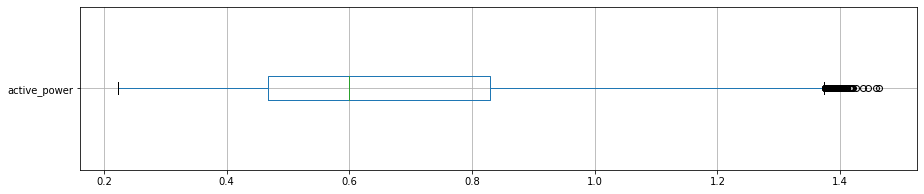

In [ ]:
data_arc[['active_power']].boxplot(figsize=(15,3), vert=False);

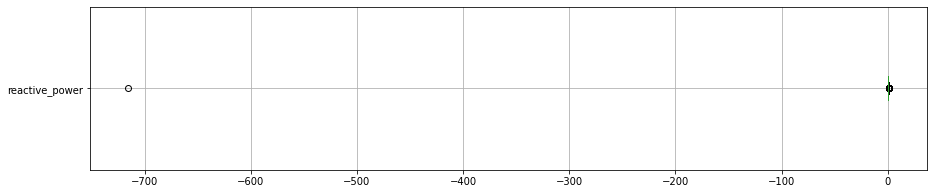

In [ ]:
data_arc[['reactive_power']].boxplot(figsize=(15,3), vert=False);

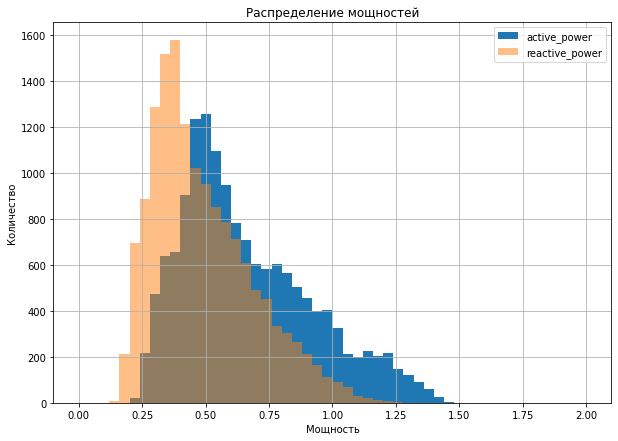

In [ ]:
data_arc['active_power'].hist(bins=50, figsize=(10,7), legend=True, range=(0,2))
data_arc['reactive_power'].hist(bins=50, figsize=(10,7), alpha=0.5, legend=True, range=(0,2))
plt.title('Распределение мощностей')
plt.xlabel('Мощность')
plt.ylabel('Количество');

In [ ]:
data_arc.query('reactive_power < -700')

,key,heating_start,heating_end,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [ ]:
data_arc.query('key==2116')

,key,heating_start,heating_end,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


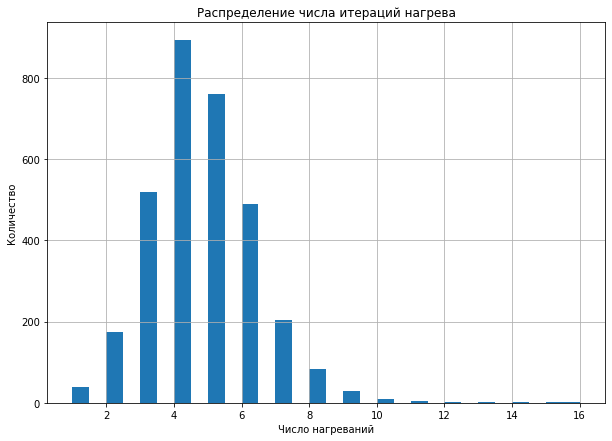

In [ ]:
# посмотрим распределение числа итераций нагрева

data_arc.groupby('key').agg({'active_power':'count'}).\
rename(columns={'key':'count'}).hist(bins=30, figsize=(10,7))
plt.title('Распределение числа итераций нагрева')
plt.xlabel('Число нагреваний')
plt.ylabel('Количество');

Медиана активной мощности 0.6, реактивной 0.44. Оба распределения близки к нормальному с хвостами справа. Есть сильный выброс по реактивной мощности (менее -715). Он присутствует у партии 2116. Этот выброс позже удалим. Чаще всего одна партия нагревается 5 раз.

**Данные о подаче сыпучих материалов (объём и время)**

In [ ]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [ ]:
# приведем названия колонок к стилю snake_case

data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']
data_bulk_time.columns = data_bulk.columns

In [ ]:
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Видимо подача сыпучих материалов начинается в таблице с конца (от `bulk_15` к `bulk_1`).

In [ ]:
print(data_bulk.info())
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  --

Переведем колонки с датой в актуальный формат.

In [ ]:
date_columns = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

In [ ]:
for column in date_columns:
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column],\
                                            format='%Y.%m.%d %H:%M:%S')

In [ ]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


Число пропусков в соответствующих колонках данных о подаче сыпучих материалов (объем - сколько, время - когда) совпадают. Видимо `NaN` означает отсутствие подачи конкретного типа `Bulk` в соответствующую итерацию. Посмотрим доли пропущенных значений. Для этого напишем функцию, визуализирующую доли пропусков по колонкам.

In [ ]:
def pass_value_barh(data):
    try:
        (
            (data.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind = 'barh', figsize=(7, 5), legend=False, fontsize = 15)
            .set_title('Доля пропущенных значений, %' + "\n", fontsize = 15)
        );
    except:
        print('Пропусков нет')

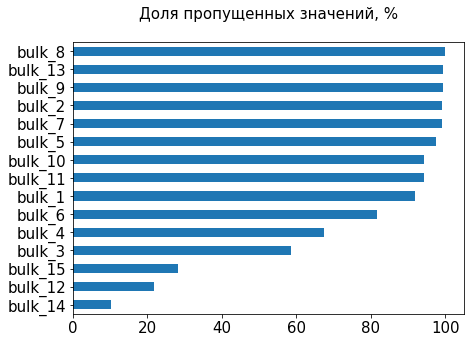

In [ ]:
# доли пропусков в данных о подаче сыпучих материалов (объём и время)

pass_value_barh(data_bulk)

Пропусков довольно много. Логичнее всего будет заполнить их нулями (пропуск - материал не использовался). Посмотрим распределения объема разных типов сыпучих материалов.

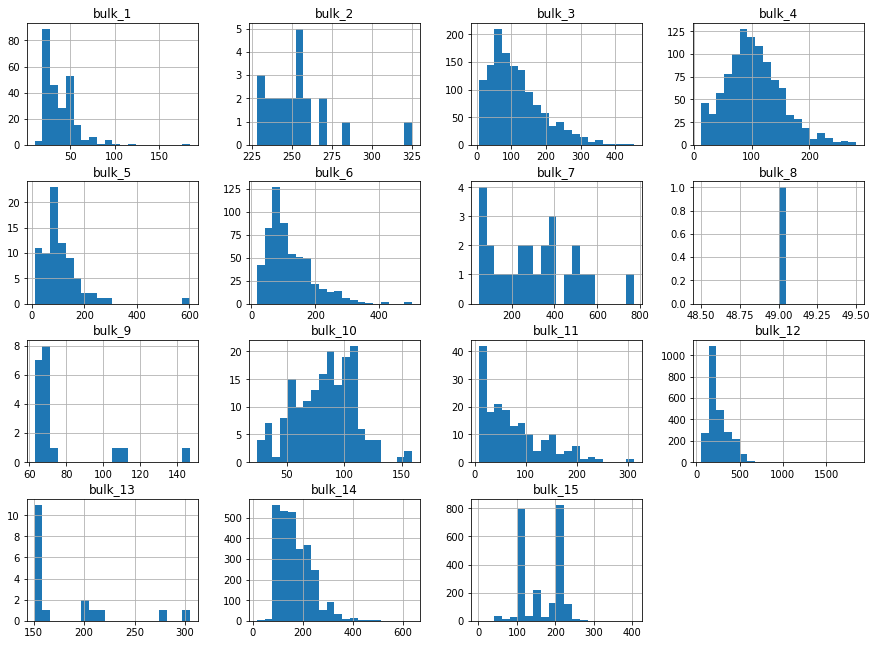

In [ ]:
# распределения объема всех типов сыпучих материалов

data_bulk.drop('key', axis=1).hist(bins=20, figsize=(15,11));

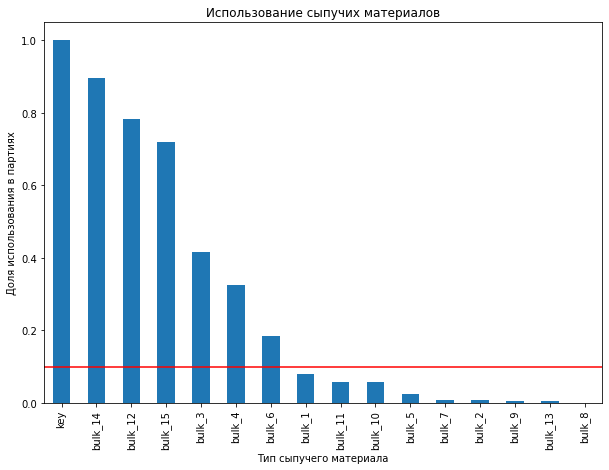

In [ ]:
# посмотрим частоту использования различных типов сыпучих материалов

data_bulk.notnull().mean().sort_values(ascending=False).plot(kind='bar', figsize=(10,7))
plt.axhline(y=0.1, color='r', linestyle='-')
plt.title('Использование сыпучих материалов')
plt.ylabel('Доля использования в партиях')
plt.xlabel('Тип сыпучего материала');

Сыпучие материалы bulk 1, 11, 10, 5, 7, 2, 9, 13, 8 - используются при изготовлении менее 10% партий. Возможно, их лучше будет исключить из обучения.

**Данные о продувке сплава газом**

In [ ]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [ ]:
data_gas.columns = ['key', 'gas']

In [ ]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нет. Перейдем к распределению.

In [ ]:
data_gas[['gas']].describe()

,gas
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


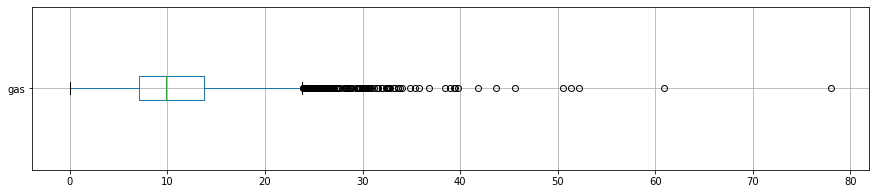

In [ ]:
data_gas[['gas']].boxplot(figsize=(15,3), vert=False);

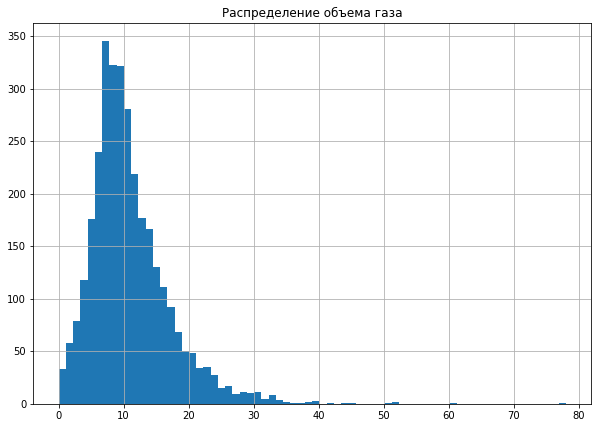

In [ ]:
data_gas['gas'].hist(bins=70, figsize=(10,7))
plt.title('Распределение объема газа');

Медиана 9.8. Выбросы примерно после 23. Распределение нормальное с хвостом справа.

**Результаты измерения температуры**

In [ ]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [ ]:
data_temp.columns = ['key', 'measure_time', 'temp']

In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   measure_time  18092 non-null  object 
 2   temp          14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Пропуски есть, посмотрим долю.

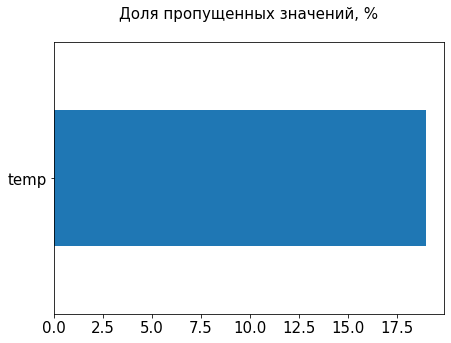

In [ ]:
# доля пропусков в результатах измерения температуры

pass_value_barh(data_temp)

In [ ]:
data_temp.query('temp.isna()').head(20)

,key,measure_time,temp
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
13933,2501,2019-08-10 15:02:56,NaN
13934,2501,2019-08-10 15:07:47,NaN
13935,2501,2019-08-10 15:16:53,NaN
13936,2501,2019-08-10 15:22:50,NaN
13937,2501,2019-08-10 15:29:00,NaN


Кажется, что пропуски измерения температур присутствуют у всех наблюдений целых отдельных партий. Проверим это. Составим список уникальных номеров партий из таблицы среза выше и сравним со срезом с этими номерами партий.

In [ ]:
# сколько измерений с пропусками?

len(data_temp.query('temp.isna()'))

3427

In [ ]:
# список партий, где в принципе есть пропуски измерения температуры

data_temp_nan_keys = data_temp.query('temp.isna()')['key'].unique()

In [ ]:
# сколько таких партий?

len(data_temp_nan_keys)

739

In [ ]:
# сколько вообще строк с измерниями в этих партиях?

len(data_temp.query('key in @data_temp_nan_keys'))

4166

In [ ]:
data_temp.query('key in @data_temp_nan_keys').head(30)

,key,measure_time,temp
13926,2500,2019-08-10 14:04:39,1539.0
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13931,2501,2019-08-10 14:41:14,1587.0
13932,2501,2019-08-10 14:49:15,NaN
13933,2501,2019-08-10 15:02:56,NaN
13934,2501,2019-08-10 15:07:47,NaN
13935,2501,2019-08-10 15:16:53,NaN


Нет, все-таки в этих партиях не все измерения пропущены. Видимо в них присутсвует первое измерение температуры и отсутсвуют дальнейшие. Таких 739 партий. Строки с пропусками температуры удалим, т.к. это целевая переменная. Изучим распределение температур.

In [ ]:
data_temp[['temp']].describe()

,temp
count,14665.000000
mean,1590.722741
std,20.394381
min,1191.000000
25%,1580.000000
50%,1590.000000
75%,1599.000000
max,1705.000000


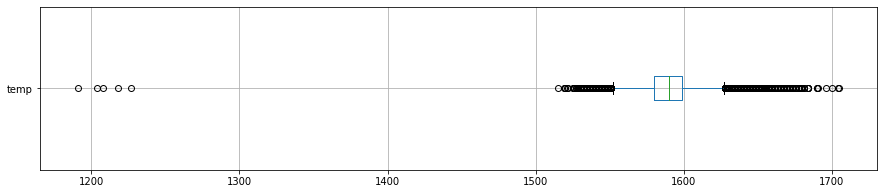

In [ ]:
# построим диаграмму размаха температур

data_temp[['temp']].boxplot(figsize=(15,3), vert=False);

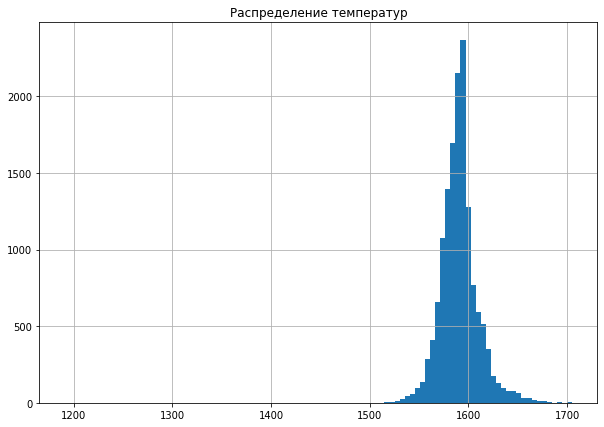

In [ ]:
data_temp['temp'].hist(bins=100, figsize=(10,7))
plt.title('Распределение температур');

Нормальное распределение с хвостом слева. Медиана 1590 градусов. Выбросы примерно до 1550 и после 1625 градусов. Очень заметные выбросы в районе 1200 градусов (возможно, это одна партия).

In [ ]:
data_temp.query('temp < 1300')

,key,measure_time,temp
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Нет. Оказалось, это измерения в разных партиях. Эти выбросы скорее всего удалим: при таких температурах сплав уже застывает.

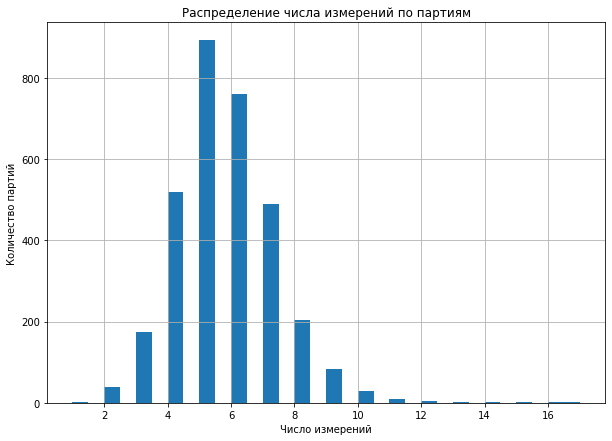

In [ ]:
# посмотрим распределение числа измерений по партиям

data_temp.groupby('key').agg({'key':'count'}).\
rename(columns={'key':'count'}).hist(bins=32, figsize=(10,7))
plt.title('Распределение числа измерений по партиям')
plt.xlabel('Число измерений')
plt.ylabel('Количество партий');

Больше всего по 5 измерений.

**Данные о проволочных материалах (объём и время)**

In [ ]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_wire.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [ ]:
# приведем названия колонок к стилю snake_case

data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', \
                     'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
data_wire_time.columns = data_wire.columns

In [ ]:
print(data_wire.info())
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      obje

Снова скорректируем формат колонок с датами.

In [ ]:
date_columns = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

In [ ]:
for column in date_columns:
    data_wire_time[column] = pd.to_datetime(data_wire_time[column],\
                                            format='%Y.%m.%d %H:%M:%S')

In [ ]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Пропуски есть. Та же ситуация, что и с пропусками в данных о сыпучих материалах: число пропусков в соответствующих колонках совпадают. Их тоже заменим нулями.

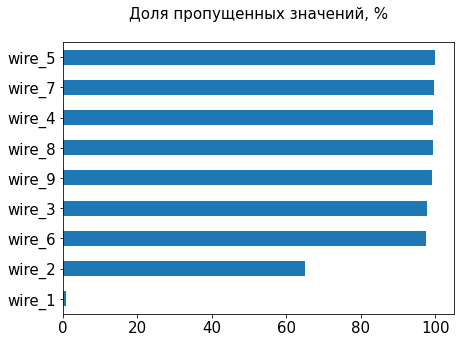

In [ ]:
# доли пропусков в данных о проволочных материалах (объём и время)

pass_value_barh(data_wire)

Встречаются большие доли пропусков. Посмотрим распределения объема разных типов проволочных материалов.

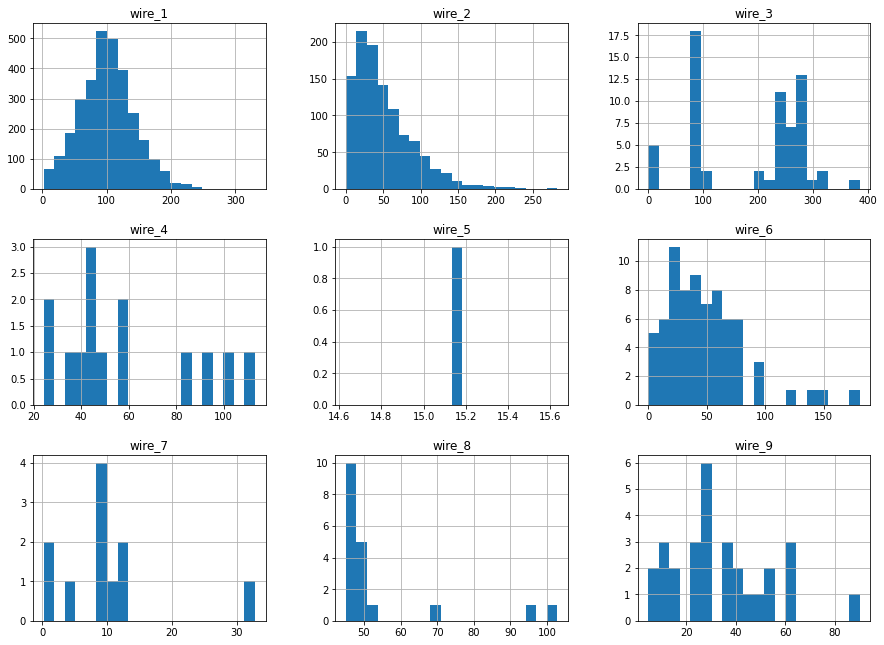

In [ ]:
data_wire.drop('key', axis=1).hist(bins=20, figsize=(15,11));

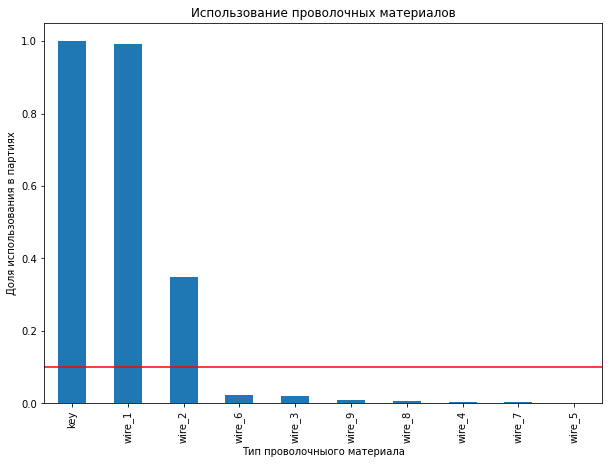

In [ ]:
# посмотрим частоту использования различных типов проволочных материалов

data_wire.notnull().mean().sort_values(ascending=False).plot(kind='bar', figsize=(10,7))
plt.axhline(y=0.1, color='r', linestyle='-')
plt.title('Использование проволочных материалов')
plt.ylabel('Доля использования в партиях')
plt.xlabel('Тип проволочныого материала');

Проволочные материалы wire 6, 3, 9, 8, 4, 7, 5 - используются в менее 10% партий. Их тоже лучше исключить из обучения.

**Выводы**

Данные об электродах и данные о продувке сплава газом - полные. Но есть пропуски в следующих данных:
- Данные о подаче сыпучих материалов (объём и время: кол-во пропусков в соответсвующих колонках совпадает) - объём заменим нулями;
- Результаты измерения температуры - пропуски температуры удалим (нет температуры - нет целевой переменной);
- Данные о проволочных материалах (объём и время: кол-во пропусков в соответсвующих колонках совпадает) - объём заменим нулями;

Есть выбросы по температуре - менее 1230 градусов - их удалим. Выброс по реактивной мощности -715 удалим. Материалы wire 6, 3, 9, 8, 4, 7, 5 и bulk 1, 11, 10, 5, 7, 2, 9, 13, 8 - используются в менее 10% партий - их тоже исключим из обучения.

**План работ**

1. Обработаем найденные пропуски и выбросы в отдельных таблицах.
3. Проведем предобработку данных для создания единого датасета, моделирующего ковш.
3. Сделаем проверку новых признаков на мультиколлинеарность.
5. Подготовим выборки и обучим разные модели.
6. Протестируем лучшую модель на тестовой выборке.

## Предобработка данных

In [ ]:
# удалим найденный выброс по реактивной мощности

data_arc = data_arc.query('reactive_power > -700')

In [ ]:
# удалим в data_arc записи по партиям,
# где есть только первый замер температуры

data_arc = data_arc.query('key not in @data_temp_nan_keys')

In [ ]:
# удалим выбросы с низкой температурой

data_temp = data_temp.query('temp > 1300')

In [ ]:
# удалим в data_temp записи по партиям,
# где есть только первый замер температуры

data_temp = data_temp.query('key not in @data_temp_nan_keys')

In [ ]:
# скопируем data_arc в переменную data
# для построения финального датасета

data = data_arc.copy()

In [ ]:
# добавим информацию по газу

data = data.merge(data_gas, on='key')

Логично предположить, что для предсказания температуры нам могут понадобиться следующие данные:
- стартовая и конечная температуры для каждой итерации в рамках каждой партии.
- суммарная работа всех мощностей от измерения стартовой до измерения конечной температуры.
- накопленная для каждой итерации суммарная работа всех мощностей от измерения стартовой до измерения конечной температуры.
- все добавленные на данной итерации материалы.
- все добавленные к моменту данной итерации материалы в рамках всей партии.

Для получения этих данных могут понадобиться промежуточные расчеты и колонки, которые могут оказаться полезными и сами по себе. Поэтому начнем добавлять важные колонки, необходимые для восстановления хронологии процесса нагревания и моделирования ковша.

In [ ]:
# суммарная мощность

data['power_sum'] = data['active_power'] + data['reactive_power']

In [ ]:
# средняя активная мощностть

for key in data['key'].unique():
    data.loc[data['key']==key, 'active_power_mean'] =\
    data.loc[data['key']==key, 'active_power'].mean()

In [ ]:
# средняя реактивная мощностть

for key in data['key'].unique():
    data.loc[data['key']==key, 'reactive_power_mean'] =\
    data.loc[data['key']==key, 'reactive_power'].mean()

In [ ]:
# длительность нагревания в секундах

data['heating_sec'] = (data['heating_end']-data['heating_start']).astype('timedelta64[s]')

In [ ]:
# накопленное время нагревания

data['heating_sec_cumulative'] = data.groupby(['key'])['heating_sec'].cumsum()

In [ ]:
# работа активной мощности

data['active_power_work'] = data['active_power'] * data['heating_sec']

In [ ]:
# накопленная работа активной мощности

data['active_power_work_cumulative'] = data.groupby(['key'])['active_power_work'].cumsum()

In [ ]:
# время следующего начала нагревания

data['next_heating_start'] = data.groupby(['key'])['heating_start'].shift(-1)

Добавим время измерения температуры и саму температуру по партиям, если измерение было в промежутке между временем конца нагревания и следующим началом нагревания.

In [ ]:
for key in data['key'].unique():
    for i, r in data.query('key==@key').iterrows():
        for j, q in data_temp.query('key==@key').iterrows():
            if pd.to_datetime(r['next_heating_start']) \
            > pd.to_datetime(q['measure_time']) \
            > pd.to_datetime(r['heating_end']):
                data.loc[(data['key']==key)
                        &(data['next_heating_start']==pd.to_datetime(r['next_heating_start']))
                        &(data['heating_end']==pd.to_datetime(r['heating_end'])), 'measure_time'] =\
                pd.to_datetime(q['measure_time'])

                data.loc[(data['key']==key)
                        &(data['next_heating_start']==pd.to_datetime(r['next_heating_start']))
                        &(data['heating_end']==pd.to_datetime(r['heating_end'])), 'temp'] = q['temp']

In [ ]:
# стартовая температура и время измерения стартовой температуры

data['starting_temp'] = data.groupby(['key'])['temp'].shift(1)
data['starting_temp_measure_time'] = data.groupby(['key'])['measure_time'].shift(1)

Для строк, где итерация в партии была **последней**, нет времени следующего начала нагревания (остатутся пропуски). Поэтому отдельно добавим время измерения температуры и саму температуру для таких строк.

In [ ]:
for key in data['key'].unique():
    for i, r in data.query('key==@key').iterrows():
        for j, q in data_temp.query('key==@key').iterrows():
            if pd.to_datetime(q['measure_time']) > pd.to_datetime(r['heating_end']):
                data.loc[(data['key']==key)&(data['measure_time'].isna())
                        &(data['heating_end']==pd.to_datetime(r['heating_end'])), 'measure_time'] =\
                pd.to_datetime(q['measure_time'])

                data.loc[(data['key']==key)&(data['temp'].isna())
                        &(data['heating_end']==pd.to_datetime(r['heating_end'])), 'temp'] = q['temp']

Для строк, где итерация в партии была **первой**,  остались пропуски времени измерения стартовой температуры и самой стартовой температуры. Отдельно заполним эти данные для таких строк.

In [ ]:
for key in data['key'].unique():
    for i, r in data.query('key==@key').iterrows():
        for j, q in data_temp.query('key==@key').iterrows():
            if pd.to_datetime(q['measure_time']) < pd.to_datetime(r['heating_start']):
                data.loc[(data['key']==key)&(data['starting_temp'].isna())
                        &(data['heating_start']==pd.to_datetime(r['heating_start'])), 'starting_temp'] = q['temp']

                data.loc[(data['key']==key)&(data['starting_temp_measure_time'].isna())
                        &(data['heating_start']==pd.to_datetime(r['heating_start'])), 'starting_temp_measure_time'] =\
                pd.to_datetime(q['measure_time'])

In [ ]:
# самая первая температура в партии

for key in data['key'].unique():
    for i in data.query('key==@key').index:
        if i == data.query('key==@key').index.min():
            data.loc[data['key'] == key, 'key_first_temp'] = data.loc[i, 'starting_temp']

In [ ]:
# длительность от конца нагревания до измерения температуры в секундах

data['after_heating_end_before_measure_sec'] =\
(data['measure_time']-data['heating_end']).astype('timedelta64[s]')

In [ ]:
# работа реактивной мощности до измерения температуры

data['reactive_power_work_before_measure'] =\
data['reactive_power'] * data['after_heating_end_before_measure_sec']

In [ ]:
# накопленная работа реактивной мощности до измерения температуры

data['reactive_power_work_before_measure_cumulative'] = data.\
groupby(['key'])['reactive_power_work_before_measure'].cumsum()

In [ ]:
# длительность от измерения стартовой температуры до начала нагревания в секундах

data['before_heating_start_sec'] = (data['heating_start']-data['starting_temp_measure_time'])\
.astype('timedelta64[s]')

In [ ]:
# реактивная мощность на предыдущей итерации

data['previous_reactive_power'] = data.groupby(['key'])['reactive_power'].shift(1)
data.loc[data['previous_reactive_power'].isna(), 'previous_reactive_power'] = 0

In [ ]:
# средняя реактивная мощностть на предыдущей итерации

for key in data['key'].unique():
    data.loc[data['key']==key, 'previous_reactive_power_mean'] = \
    data.loc[data['key']==key, 'previous_reactive_power'].mean()

In [ ]:
# работа реактивной мощности до начала нагревания

data['reactive_power_work_before_heating_start'] = \
data['previous_reactive_power'] * data['before_heating_start_sec']

In [ ]:
# накопленная работа реактивной мощности до начала нагревания

data['reactive_power_work_before_heating_start_cumulative'] = data.\
groupby(['key'])['reactive_power_work_before_heating_start'].cumsum()

In [ ]:
# суммарная работа всех мощностей

data['iteration_power_work_sum'] = data['reactive_power_work_before_heating_start'] +\
data['active_power_work'] + data['reactive_power_work_before_measure']

In [ ]:
# накопленная суммарная работа всех мощностей

data['iteration_power_work_sum_cumulative'] = data.groupby(['key'])['iteration_power_work_sum'].cumsum()

In [ ]:
data.head(10)

,key,heating_start,heating_end,active_power,reactive_power,gas,power_sum,active_power_mean,reactive_power_mean,heating_sec,...,after_heating_end_before_measure_sec,reactive_power_work_before_measure,reactive_power_work_before_measure_cumulative,before_heating_start_sec,previous_reactive_power,previous_reactive_power_mean,reactive_power_work_before_heating_start,reactive_power_work_before_heating_start_cumulative,iteration_power_work_sum,iteration_power_work_sum_cumulative
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,29.749986,0.516383,0.607346,0.428564,228.0,...,76.0,16.055228,16.055228,10.0,0.000000,0.299826,0.00000,0.00000,85.624868,85.624868
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,29.749986,1.243096,0.607346,0.428564,185.0,...,61.0,29.123718,45.178946,10.0,0.211253,0.299826,2.11253,2.11253,172.882978,258.507846
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,29.749986,1.010773,0.607346,0.428564,172.0,...,208.0,89.535680,134.714626,10.0,0.477438,0.299826,4.77438,6.88691,194.123896,452.631742
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,29.749986,0.898475,0.607346,0.428564,365.0,...,100.0,37.997900,172.712526,10.0,0.430460,0.299826,4.30460,11.19151,231.553540,684.185282
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,29.749986,1.510824,0.607346,0.428564,148.0,...,121.0,77.886611,250.599137,10.0,0.379979,0.299826,3.79979,14.99130,210.022085,894.207367
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,12.555561,0.601475,0.534852,0.363339,137.0,...,129.0,28.425279,28.425279,10.0,0.000000,0.227710,0.00000,0.00000,80.639267,80.639267
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,12.555561,0.467192,0.534852,0.363339,338.0,...,101.0,20.758227,49.183506,10.0,0.220351,0.227710,2.20351,2.20351,111.404507,192.043774
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,12.555561,1.195259,0.534852,0.363339,126.0,...,73.0,35.402226,84.585732,10.0,0.205527,0.227710,2.05527,4.25878,126.954918,318.998692
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,12.555561,1.328839,0.534852,0.363339,210.0,...,111.0,60.219387,144.805119,10.0,0.484962,0.227710,4.84962,9.10840,230.196627,549.195319
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,28.554793,1.922534,0.812728,0.587491,280.0,...,128.0,105.069568,105.069568,10.0,0.000000,0.532979,0.00000,0.00000,413.539408,413.539408


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11438 entries, 0 to 11437
Data columns (total 29 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   key                                                  11438 non-null  int64         
 1   heating_start                                        11438 non-null  datetime64[ns]
 2   heating_end                                          11438 non-null  datetime64[ns]
 3   active_power                                         11438 non-null  float64       
 4   reactive_power                                       11438 non-null  float64       
 5   gas                                                  11438 non-null  float64       
 6   power_sum                                            11438 non-null  float64       
 7   active_power_mean                                    11438 non-null  float64       
 

Удалим ненужные колонки (`bulk 1, 11, 10, 5, 7, 2, 9, 13, 8`) из таблиц с данными о подаче сыпучих материалов.

In [ ]:
data_bulk.drop(['bulk_1', 'bulk_2', 'bulk_5',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11',
       'bulk_13'], axis=1, inplace=True)
data_bulk_time.drop(['bulk_1', 'bulk_2', 'bulk_5',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11',
       'bulk_13'], axis=1, inplace=True)

In [ ]:
# соединим информацию о сыпучих материалах в один датасет

data_bulk_join = data_bulk.join(data_bulk_time, how='inner', rsuffix='_time').\
drop('key_time', axis=1)

In [ ]:
data_bulk.columns

Index(['key', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15'], dtype='object')

In [ ]:
# создадим список с названиями оставшихся материалов

bulks = ['bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15']

Напишем функцию для перевода данных с материалами и временем их подачи в более удобную для восприятия и дальнейшей работы структуру.

In [ ]:
def data_melt(data_bulk_join, bulks):
    data_bulk_melt = pd.DataFrame()

    for bulk in bulks:
        data_current_bulk = data_bulk_join[['key', str(bulk), str(bulk) + '_time']] \
            .melt(id_vars=['key', str(bulk) + '_time'], value_vars=[str(bulk)]).dropna()
        data_current_bulk.columns = ['key', 'datetime', 'variable', 'value']

        data_bulk_melt = pd.concat([data_bulk_melt, data_current_bulk])

    data_bulk_melt['datetime'] = pd.to_datetime(data_bulk_melt['datetime'])

    return data_bulk_melt

In [ ]:
data_bulk_melt = data_melt(data_bulk_join, bulks)
data_bulk_melt = data_bulk_melt.query('key not in @data_temp_nan_keys') # удалим ненужные партии
data_bulk_melt

,key,datetime,variable,value
13,14,2019-05-03 20:40:25,bulk_3,71.0
20,21,2019-05-04 04:25:29,bulk_3,151.0
21,22,2019-05-04 05:15:12,bulk_3,63.0
23,24,2019-05-04 07:13:45,bulk_3,89.0
24,25,2019-05-04 08:13:13,bulk_3,132.0
...,...,...,...,...
2403,2495,2019-08-10 11:37:27,bulk_15,223.0
2404,2496,2019-08-10 12:03:50,bulk_15,226.0
2405,2497,2019-08-10 12:51:38,bulk_15,226.0
2406,2498,2019-08-10 13:07:38,bulk_15,207.0


Напишем функцию для добавления данных о подаче материалов в основной датасет.

In [ ]:
def add_materials(data, data_bulk_melt, bulks):
    for key in data['key'].unique():
        for i, r in data.query('key==@key').iterrows():
            for j, q in data_bulk_melt.query('key==@key').iterrows():
                if pd.to_datetime(r['heating_end'])\
                < pd.to_datetime(q['datetime'])\
                < pd.to_datetime(r['measure_time']):
                    data.loc[(data['key']==key)
                            &(data['heating_end']==pd.to_datetime(r['heating_end']))
                            &(data['measure_time']==pd.to_datetime(r['measure_time'])), q['variable']] =\
                    q['value']
    for bulk in bulks:
        data.loc[data[bulk].isna(), bulk] = 0

    # добавляем все добавленные к моменту данной итерации материалы в рамках всей партии.
    for key in data['key'].unique():
        for i in data.query('key==@key').index:
            for bulk in bulks:
                if (data.loc[i, bulk] != 0) and (i != data.query('key==@key').index.max()):
                    data.loc[i+1, bulk] = data.loc[i, bulk]
    return data

In [ ]:
data = add_materials(data, data_bulk_melt, bulks)
data

,key,heating_start,heating_end,active_power,reactive_power,gas,power_sum,active_power_mean,reactive_power_mean,heating_sec,...,reactive_power_work_before_heating_start,reactive_power_work_before_heating_start_cumulative,iteration_power_work_sum,iteration_power_work_sum_cumulative,bulk_15,bulk_14,bulk_12,bulk_4,bulk_6,bulk_3
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,29.749986,0.516383,0.607346,0.428564,228.0,...,0.00000,0.00000,85.624868,85.624868,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,29.749986,1.243096,0.607346,0.428564,185.0,...,2.11253,2.11253,172.882978,258.507846,154.0,0.0,0.0,0.0,0.0,0.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,29.749986,1.010773,0.607346,0.428564,172.0,...,4.77438,6.88691,194.123896,452.631742,154.0,150.0,0.0,0.0,0.0,0.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,29.749986,0.898475,0.607346,0.428564,365.0,...,4.30460,11.19151,231.553540,684.185282,154.0,150.0,206.0,0.0,0.0,0.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,29.749986,1.510824,0.607346,0.428564,148.0,...,3.79979,14.99130,210.022085,894.207367,154.0,150.0,206.0,43.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11433,2498,2019-08-10 13:20:18,2019-08-10 13:20:59,0.508786,0.363916,14.953657,0.872702,0.640462,0.447964,41.0,...,6.43639,18.75904,82.611848,844.015861,207.0,129.0,206.0,0.0,0.0,90.0
11434,2499,2019-08-10 13:33:31,2019-08-10 13:38:43,0.700677,0.534767,11.336151,1.235444,0.434271,0.324209,312.0,...,0.00000,0.00000,310.056381,310.056381,0.0,0.0,0.0,0.0,0.0,0.0
11435,2499,2019-08-10 13:41:44,2019-08-10 13:45:09,0.333776,0.269695,11.336151,0.603471,0.434271,0.324209,205.0,...,5.34767,5.34767,95.077655,405.134036,0.0,0.0,0.0,0.0,0.0,0.0
11436,2499,2019-08-10 13:46:38,2019-08-10 13:51:33,0.406252,0.263303,11.336151,0.669555,0.434271,0.324209,295.0,...,2.69695,8.04462,175.991799,581.125835,227.0,0.0,0.0,0.0,0.0,0.0


Теперь переструктурируем данные о подаче проволочных материалов. Удалим ненужные колонки (`wire 6, 3, 9, 8, 4, 7, 5`).

In [ ]:
data_wire.drop(['wire_3', 'wire_4', 'wire_5',
       'wire_6', 'wire_7', 'wire_8', 'wire_9'], axis=1, inplace=True)
data_wire_time.drop(['wire_3', 'wire_4', 'wire_5',
       'wire_6', 'wire_7', 'wire_8', 'wire_9'], axis=1, inplace=True)

In [ ]:
# соединим информацию о проволочных материалах в один датасет

data_wire_join = data_wire.join(data_wire_time, how='inner', rsuffix='_time').\
drop('key_time', axis=1)

In [ ]:
# создадим список с названиями оставшихся материалов

wires = ['wire_1', 'wire_2']

In [ ]:
data_wire_melt = data_melt(data_wire_join, wires)
data_wire_melt = data_wire_melt.query('key not in @data_temp_nan_keys') # удалим ненужные партии
data_wire_melt

,key,datetime,variable,value
0,1,2019-05-03 11:06:19,wire_1,60.059998
1,2,2019-05-03 11:36:50,wire_1,96.052315
2,3,2019-05-03 12:11:46,wire_1,91.160157
3,4,2019-05-03 12:43:22,wire_1,89.063515
4,5,2019-05-03 13:20:44,wire_1,89.238236
...,...,...,...,...
2359,2485,2019-08-10 00:17:56,wire_2,42.103359
2361,2487,2019-08-10 01:53:48,wire_2,85.413121
2362,2488,2019-08-10 06:15:31,wire_2,37.066639
2370,2497,2019-08-10 12:40:30,wire_2,9.048000


In [ ]:
data = add_materials(data, data_wire_melt, wires)
data

,key,heating_start,heating_end,active_power,reactive_power,gas,power_sum,active_power_mean,reactive_power_mean,heating_sec,...,iteration_power_work_sum,iteration_power_work_sum_cumulative,bulk_15,bulk_14,bulk_12,bulk_4,bulk_6,bulk_3,wire_1,wire_2
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,29.749986,0.516383,0.607346,0.428564,228.0,...,85.624868,85.624868,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,0.00000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,29.749986,1.243096,0.607346,0.428564,185.0,...,172.882978,258.507846,154.0,0.0,0.0,0.0,0.0,0.0,60.059998,0.00000
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,29.749986,1.010773,0.607346,0.428564,172.0,...,194.123896,452.631742,154.0,150.0,0.0,0.0,0.0,0.0,60.059998,0.00000
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,29.749986,0.898475,0.607346,0.428564,365.0,...,231.553540,684.185282,154.0,150.0,206.0,0.0,0.0,0.0,60.059998,0.00000
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,29.749986,1.510824,0.607346,0.428564,148.0,...,210.022085,894.207367,154.0,150.0,206.0,43.0,0.0,0.0,60.059998,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11433,2498,2019-08-10 13:20:18,2019-08-10 13:20:59,0.508786,0.363916,14.953657,0.872702,0.640462,0.447964,41.0,...,82.611848,844.015861,207.0,129.0,206.0,0.0,0.0,90.0,118.110717,0.00000
11434,2499,2019-08-10 13:33:31,2019-08-10 13:38:43,0.700677,0.534767,11.336151,1.235444,0.434271,0.324209,312.0,...,310.056381,310.056381,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,50.00528
11435,2499,2019-08-10 13:41:44,2019-08-10 13:45:09,0.333776,0.269695,11.336151,0.603471,0.434271,0.324209,205.0,...,95.077655,405.134036,0.0,0.0,0.0,0.0,0.0,0.0,110.160958,50.00528
11436,2499,2019-08-10 13:46:38,2019-08-10 13:51:33,0.406252,0.263303,11.336151,0.669555,0.434271,0.324209,295.0,...,175.991799,581.125835,227.0,0.0,0.0,0.0,0.0,0.0,110.160958,50.00528


In [ ]:
data['key'].nunique()

2473

In [ ]:
data.sort_values(by='key').tail()

,key,heating_start,heating_end,active_power,reactive_power,gas,power_sum,active_power_mean,reactive_power_mean,heating_sec,...,iteration_power_work_sum,iteration_power_work_sum_cumulative,bulk_15,bulk_14,bulk_12,bulk_4,bulk_6,bulk_3,wire_1,wire_2
11430,2498,2019-08-10 13:05:13,2019-08-10 13:07:26,0.436561,0.289814,14.953657,0.726375,0.640462,0.447964,133.0,...,77.539901,227.993447,207.0,0.0,0.0,0.0,0.0,0.0,118.110717,0.00000
11435,2499,2019-08-10 13:41:44,2019-08-10 13:45:09,0.333776,0.269695,11.336151,0.603471,0.434271,0.324209,205.0,...,95.077655,405.134036,0.0,0.0,0.0,0.0,0.0,0.0,110.160958,50.00528
11436,2499,2019-08-10 13:46:38,2019-08-10 13:51:33,0.406252,0.263303,11.336151,0.669555,0.434271,0.324209,295.0,...,175.991799,581.125835,227.0,0.0,0.0,0.0,0.0,0.0,110.160958,50.00528
11434,2499,2019-08-10 13:33:31,2019-08-10 13:38:43,0.700677,0.534767,11.336151,1.235444,0.434271,0.324209,312.0,...,310.056381,310.056381,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,50.00528
11437,2499,2019-08-10 13:55:06,2019-08-10 13:56:17,0.296379,0.229071,11.336151,0.525450,0.434271,0.324209,71.0,...,60.556370,641.682205,227.0,126.0,233.0,0.0,0.0,47.0,110.160958,50.00528


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11438 entries, 0 to 11437
Data columns (total 37 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   key                                                  11438 non-null  int64         
 1   heating_start                                        11438 non-null  datetime64[ns]
 2   heating_end                                          11438 non-null  datetime64[ns]
 3   active_power                                         11438 non-null  float64       
 4   reactive_power                                       11438 non-null  float64       
 5   gas                                                  11438 non-null  float64       
 6   power_sum                                            11438 non-null  float64       
 7   active_power_mean                                    11438 non-null  float64       
 

Если попытаться примерно восстановить хронологию процесса, то это будет выглядеть как-то так:

In [ ]:
data[['key', 'starting_temp_measure_time', 'starting_temp',\
    'previous_reactive_power', 'before_heating_start_sec',\
    'reactive_power_work_before_heating_start',\
    'reactive_power_work_before_heating_start_cumulative',\
    'heating_start', 'active_power', 'heating_sec', 'active_power_work',\
    'active_power_work_cumulative', 'heating_end', 'reactive_power',\
    'after_heating_end_before_measure_sec', 'reactive_power_work_before_measure',\
    'reactive_power_work_before_measure_cumulative', 'iteration_power_work_sum',\
    'iteration_power_work_sum_cumulative','bulk_15', 'bulk_14', 'bulk_12',\
    'bulk_4', 'bulk_6', 'bulk_3', 'wire_1', 'wire_2',\
    'gas', 'measure_time', 'temp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11438 entries, 0 to 11437
Data columns (total 30 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   key                                                  11438 non-null  int64         
 1   starting_temp_measure_time                           11434 non-null  datetime64[ns]
 2   starting_temp                                        11434 non-null  float64       
 3   previous_reactive_power                              11438 non-null  float64       
 4   before_heating_start_sec                             11434 non-null  float64       
 5   reactive_power_work_before_heating_start             11434 non-null  float64       
 6   reactive_power_work_before_heating_start_cumulative  11434 non-null  float64       
 7   heating_start                                        11438 non-null  datetime64[ns]
 

Исследуем некоторые признаки нового датасета.

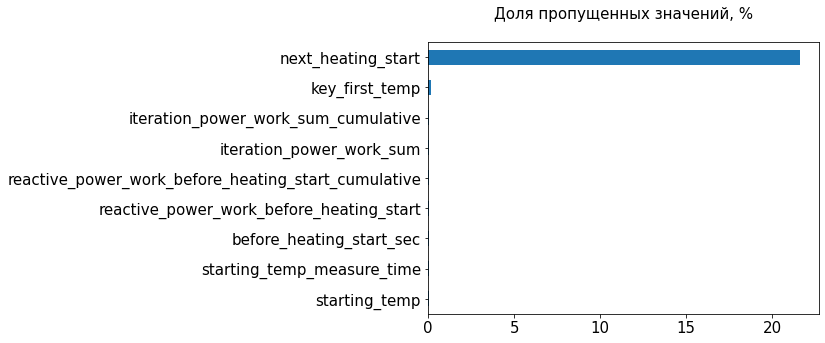

In [ ]:
# посмотрим доли пропусков

pass_value_barh(data)

In [ ]:
# удалим колонку начала следующего нагревания

data.drop('next_heating_start', axis=1, inplace=True)

In [ ]:
# удалим строки с пропусками

data.dropna(inplace=True)

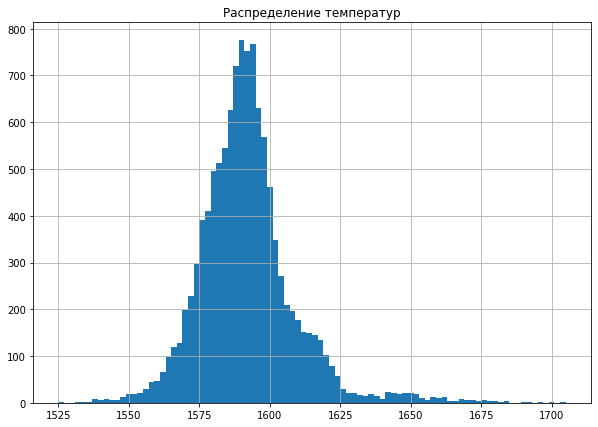

In [ ]:
# посмотрим на новое распределение температур

data['temp'].hist(bins=90, figsize=(10,7))
plt.title('Распределение температур');

Нормальное распределение. Невооруженным взлядом видно некоторые выбросы по бокам, но они не должны помешать обучению.

In [ ]:
# продолжительность разных этапов процесса

data_duration = data[['before_heating_start_sec', 'heating_sec',\
                      'after_heating_end_before_measure_sec']]

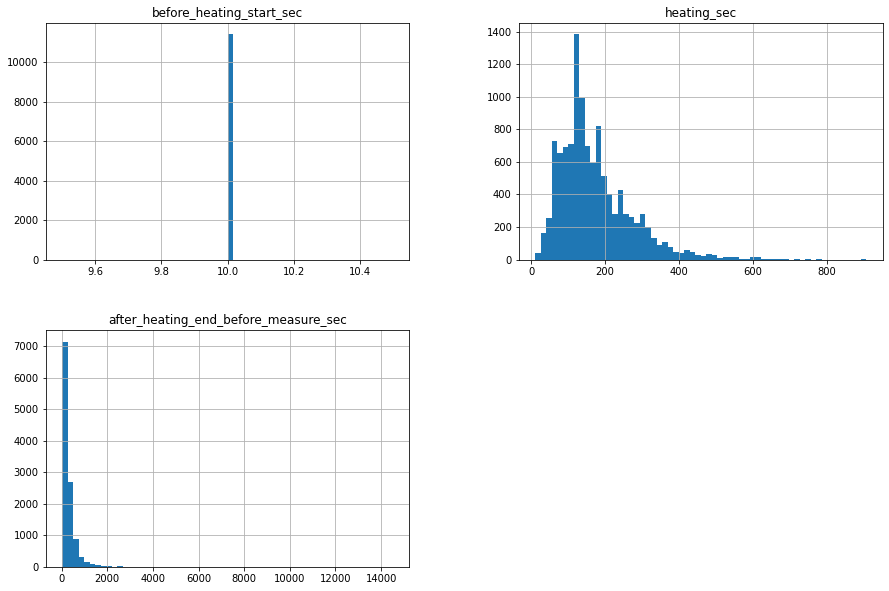

In [ ]:
data_duration.hist(bins=60, figsize=(15,10))
plt.title('Распределение времени на разных этапах процесса');

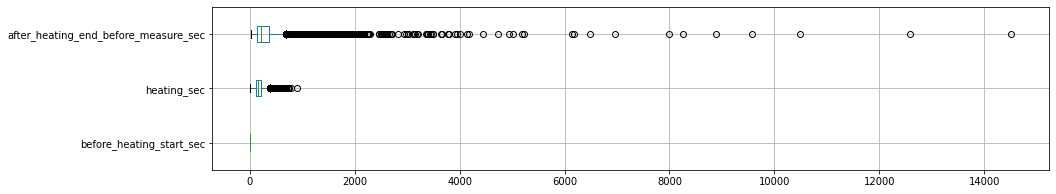

In [ ]:
# построим диаграмму размаха времени на разных этапах процесса

data_duration.boxplot(figsize=(15,3), vert=False);

In [ ]:
data_duration.describe()

,before_heating_start_sec,heating_sec,after_heating_end_before_measure_sec
count,11421.0,11421.000000,11421.000000
mean,10.0,172.987129,310.190439
std,0.0,98.636561,436.502375
min,10.0,11.000000,20.000000
25%,10.0,108.000000,129.000000
50%,10.0,147.000000,205.000000
75%,10.0,218.000000,356.000000
max,10.0,907.000000,14518.000000


Время от начального измерения до начала нагревания - стабильно 10 секунд. Само нагревание от 11 до 907 секунд. Но самое интересное, что время после нагревания и до измерения - от 20 до 14518 секунд. Достаточно много таких наблюдений, где измерение температуры было через достаточно большой промежуток времени после окончания нагрева.

In [ ]:
# разные виды мощности

data_power = data[['previous_reactive_power', 'active_power', 'reactive_power']]

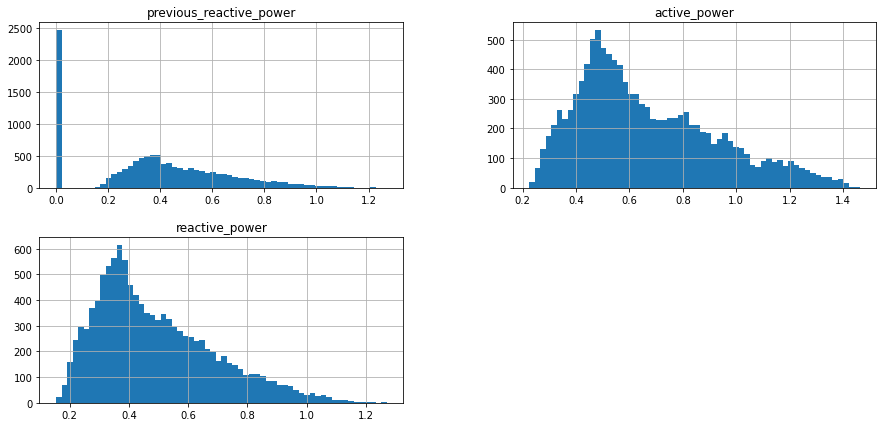

In [ ]:
# распределение разных видов мощности

data_power.hist(bins=60, figsize=(15,7));

С мощностями все по прежнему. Есть нулевые начальные реактивные мощности (до начала нагрева) - у самых первых итераций в рамках одной партии.

In [ ]:
# работы разных мощностей

data_power_work = data[['reactive_power_work_before_heating_start', 'active_power_work',\
                        'reactive_power_work_before_measure', 'iteration_power_work_sum']]

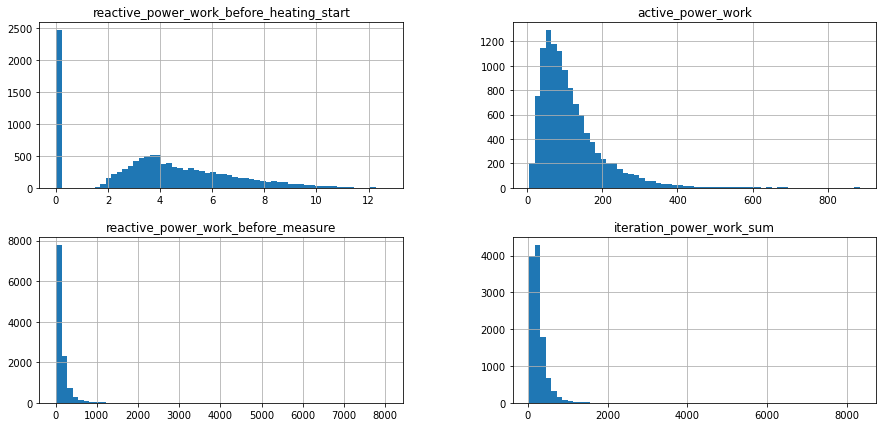

In [ ]:
# распределения работ разных мощностей

data_power_work.hist(bins=60, figsize=(15,7));

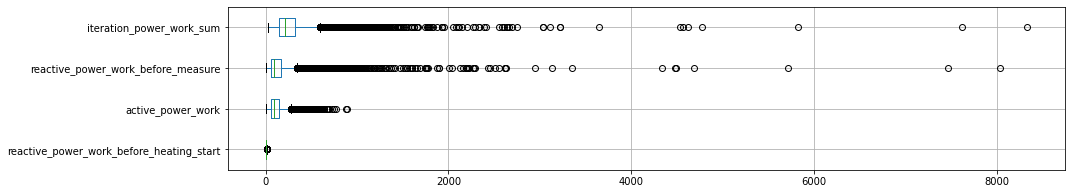

In [ ]:
data_power_work.boxplot(figsize=(15,3), vert=False);

In [ ]:
data_power_work.describe()

,reactive_power_work_before_heating_start,active_power_work,reactive_power_work_before_measure,iteration_power_work_sum
count,11421.000000,11421.000000,11421.000000,11421.000000
mean,3.849232,115.413857,152.138128,271.401217
std,2.688483,83.638021,236.421795,263.492954
min,0.000000,5.246505,7.708448,29.580353
25%,2.276380,57.851300,54.705051,141.349000
50%,3.819190,93.464820,94.619276,213.194880
75%,5.601020,147.216180,171.771440,320.766258
max,12.702840,885.343872,8038.682432,8325.766164


Где-то начальная работа (до начала нагревания) нулевая, т.к есть нулевые начальные реактивные мощности. Работа активной мощности имеет нормальное распределение с некоторым хвостом справа. Больше всех выделяется работа реактивной мощности после нагрева и до измерения: очевидно влияет наличие больших промежутков времени на этом этапе. Этот финальный этап больше всех влияет на распределение суммарной работы всех мощностей.

In [ ]:
# посмотрим корреляцию всех признаков с конечной температурой

data.corr()['temp'].sort_values(ascending=False)

temp                                                   1.000000
starting_temp                                          0.792067
key_first_temp                                         0.591874
heating_sec_cumulative                                 0.123707
active_power_work_cumulative                           0.108811
bulk_12                                                0.106094
wire_1                                                 0.082977
reactive_power_work_before_heating_start_cumulative    0.080317
bulk_4                                                 0.080250
iteration_power_work_sum_cumulative                    0.072521
bulk_14                                                0.070404
bulk_15                                                0.064892
reactive_power_work_before_heating_start               0.053329
previous_reactive_power                                0.053329
reactive_power_work_before_measure_cumulative          0.047401
iteration_power_work_sum                

Как видно, конечная температура больше всего связана с начальной (0.79), а также стартовой температурой в партии (0.59)

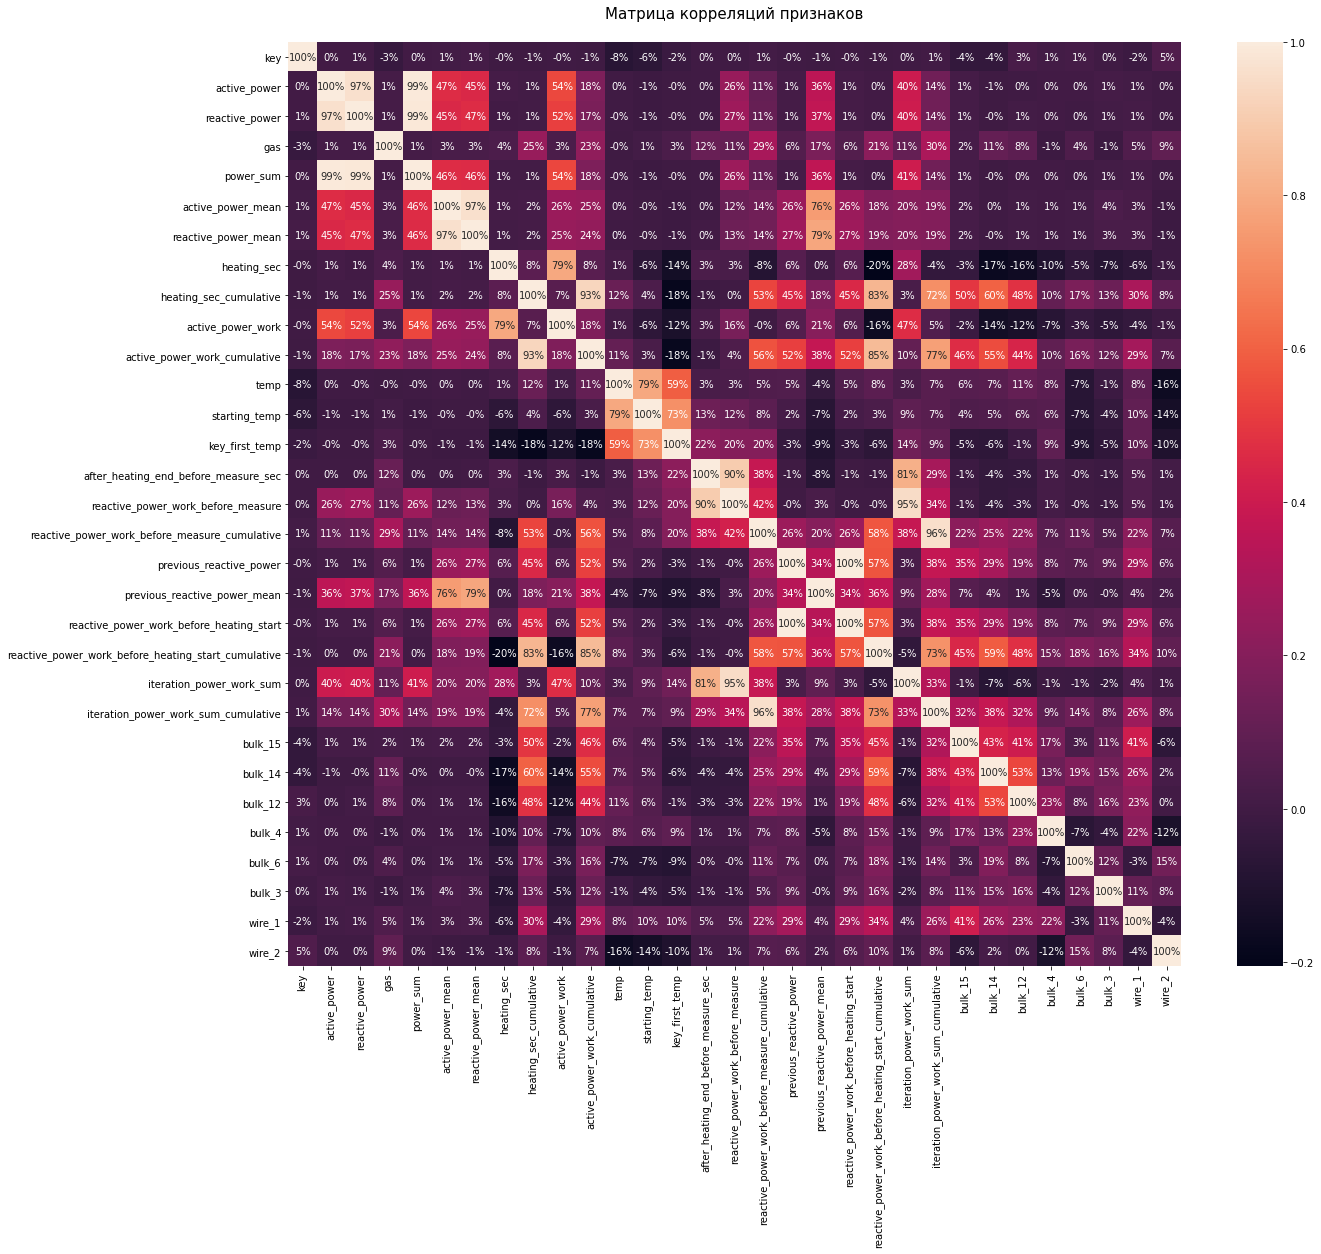

In [ ]:
plt.figure(figsize=(20, 17))
sns.heatmap(data.drop('before_heating_start_sec', axis=1).corr(), annot=True, fmt='.0%')
plt.title('Матрица корреляций признаков'+'\n', fontsize=15);

Выявлены следующие заметные корреляции:
- 100% предыдущая реактивная мощность с работой реактивной мощности до начала нагревания.
- 99% суммарная мощность с активной и реактивной мощностями.
- 97% средняя активная мощность со средней реактивной мощностью.
- 96% накопленная работа реактивной мощности до измерения температуры с суммарной накопленной работой.
- 95% работа реактивной мощности до измерения температуры с суммарной работой.
- 93% суммарное время нагрева с накопленной работой активной мощности.
- 90% время до измерения темепературы и работа реактивной мощности до измерения температуры.

Т.к. у нас задача в итоге смоделировать ковш, то переведем данные в формат "одна строка - один ковш". Оставим последнюю строчку в каждой итерации: она содержит всю необходимую информацию по партии. Оставим самые ключевые колонки.

In [ ]:
data_final = data.groupby('key')[data.columns].last()

In [ ]:
data_final.drop('key', axis=1, inplace=True)

In [ ]:
data_final.reset_index(inplace=True)

In [ ]:
data_final

,key,heating_start,heating_end,active_power,reactive_power,gas,power_sum,active_power_mean,reactive_power_mean,heating_sec,...,iteration_power_work_sum,iteration_power_work_sum_cumulative,bulk_15,bulk_14,bulk_12,bulk_4,bulk_6,bulk_3,wire_1,wire_2
0,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,29.749986,1.510824,0.607346,0.428564,148.0,...,210.022085,894.207367,154.0,150.0,206.0,43.0,0.0,0.0,60.059998,0.00000
1,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,12.555561,1.328839,0.534852,0.363339,210.0,...,230.196627,549.195319,154.0,149.0,206.0,73.0,0.0,0.0,96.052315,0.00000
2,3,2019-05-03 12:31:14,2019-05-03 12:32:19,0.421693,0.272562,28.554793,0.694255,0.812728,0.587491,65.0,...,95.465321,1209.981732,153.0,152.0,205.0,34.0,0.0,0.0,91.160157,0.00000
3,4,2019-05-03 12:53:12,2019-05-03 12:57:50,0.864995,0.654661,18.841219,1.519656,0.676622,0.514248,278.0,...,323.508737,790.444811,154.0,153.0,207.0,81.0,0.0,0.0,89.063515,0.00000
4,5,2019-05-03 13:32:44,2019-05-03 13:33:55,0.892957,0.660807,5.413692,1.553764,0.563238,0.421998,71.0,...,174.858945,690.896630,152.0,151.0,203.0,78.0,0.0,0.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2464,2495,2019-08-10 11:46:26,2019-08-10 11:48:05,0.862070,0.661810,7.125735,1.523880,0.792033,0.552734,99.0,...,197.661650,927.096151,223.0,129.0,256.0,0.0,0.0,21.0,89.150879,0.00000
2465,2496,2019-08-10 12:19:19,2019-08-10 12:23:07,1.309449,0.824095,9.412616,2.133544,0.695820,0.478672,228.0,...,410.600082,1042.413323,226.0,129.0,256.0,63.0,0.0,0.0,114.179527,0.00000
2466,2497,2019-08-10 12:47:54,2019-08-10 12:51:20,1.270521,0.906829,6.271699,2.177350,1.201746,0.817364,206.0,...,384.663198,995.583206,226.0,124.0,230.0,85.0,0.0,0.0,94.086723,9.04800
2467,2498,2019-08-10 13:20:18,2019-08-10 13:20:59,0.508786,0.363916,14.953657,0.872702,0.640462,0.447964,41.0,...,82.611848,844.015861,207.0,129.0,206.0,0.0,0.0,90.0,118.110717,0.00000


In [ ]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2469 entries, 0 to 2468
Data columns (total 36 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   key                                                  2469 non-null   int64         
 1   heating_start                                        2469 non-null   datetime64[ns]
 2   heating_end                                          2469 non-null   datetime64[ns]
 3   active_power                                         2469 non-null   float64       
 4   reactive_power                                       2469 non-null   float64       
 5   gas                                                  2469 non-null   float64       
 6   power_sum                                            2469 non-null   float64       
 7   active_power_mean                                    2469 non-null   float64       
 8 

Теперь нас больше интересуют накопленные признаки, а не промежуточные.

In [ ]:
data_final = data_final[['key_first_temp', 'temp', 'gas',\
                        'heating_sec_cumulative', 'active_power_mean',\
                        'reactive_power_mean', 'previous_reactive_power_mean',\
                         'active_power_work_cumulative',\
                         'reactive_power_work_before_measure_cumulative',\
                         'reactive_power_work_before_heating_start_cumulative',\
                         'iteration_power_work_sum_cumulative',\
                        'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15',
                        'wire_1', 'wire_2']]

In [ ]:
# оставим только те партии, где добавляли материалы
# из обеих групп (и сыпучие, и проволочные)

data_final = data_final.query('(bulk_3!=0 or bulk_4!=0 or bulk_6!=0 or bulk_12!=0 or\
 bulk_14!=0 or bulk_15!=0) and (wire_1!=0 or wire_2!=0)')

In [ ]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2300 entries, 0 to 2468
Data columns (total 19 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   key_first_temp                                       2300 non-null   float64
 1   temp                                                 2300 non-null   float64
 2   gas                                                  2300 non-null   float64
 3   heating_sec_cumulative                               2300 non-null   float64
 4   active_power_mean                                    2300 non-null   float64
 5   reactive_power_mean                                  2300 non-null   float64
 6   previous_reactive_power_mean                         2300 non-null   float64
 7   active_power_work_cumulative                         2300 non-null   float64
 8   reactive_power_work_before_measure_cumulative        2300 non-null  

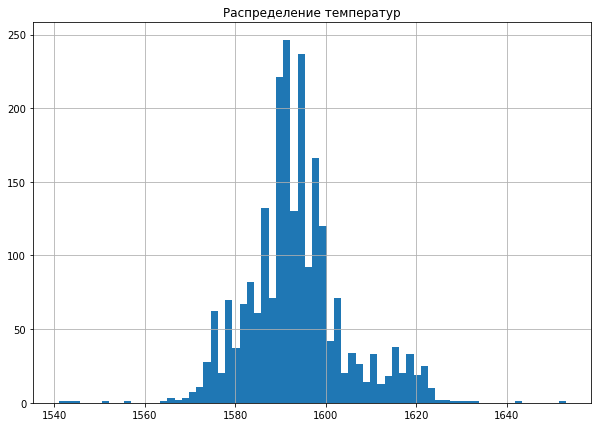

In [ ]:
# посмотрим на новое распределение температур

data_final['temp'].hist(bins=70, figsize=(10,7))
plt.title('Распределение температур');

Нормальное распределение. Снова невооруженным взлядом видно некоторые выбросы по бокам, но они не должны помешать обучению.

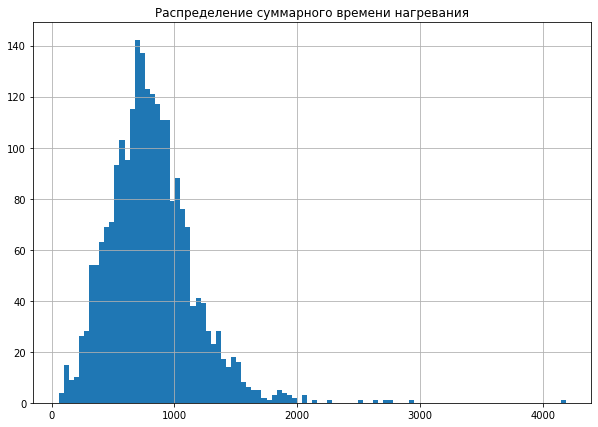

In [ ]:
# посмотрим на новое распределение времени нагревания

data_final['heating_sec_cumulative'].hist(bins=100, figsize=(10,7))
plt.title('Распределение суммарного времени нагревания');

Нормальное распределение с правым хвостом. Видно выбросы за 4000 секундами.

In [ ]:
# разные виды средних мощностей

data_power = data_final[['previous_reactive_power_mean', 'active_power_mean', 'reactive_power_mean']]

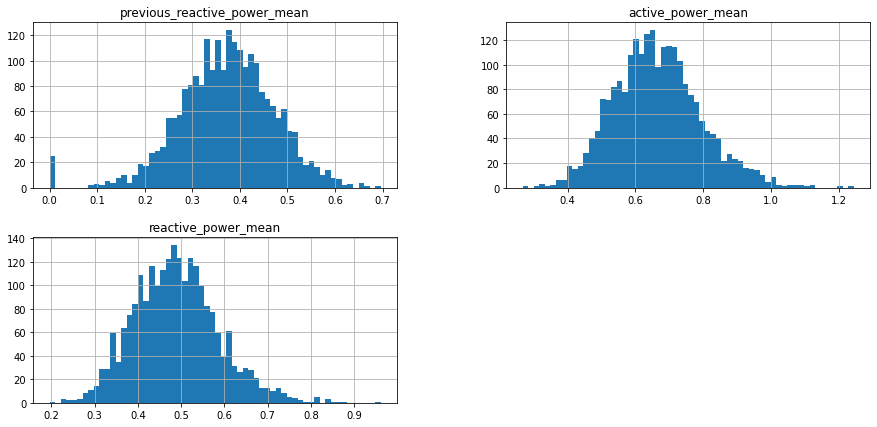

In [ ]:
# распределение разных видов средних мощностей

data_power.hist(bins=60, figsize=(15,7));

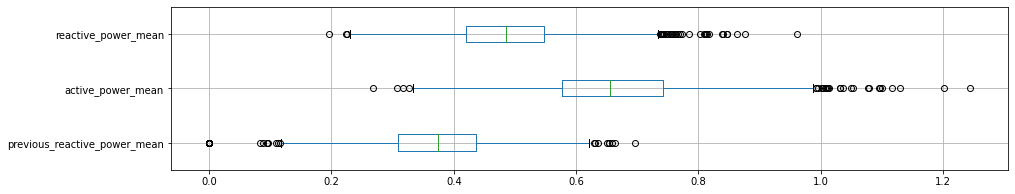

In [ ]:
data_power.boxplot(figsize=(15,3), vert=False);

Ожидаемо активная мощность смещена правее. Распределения нормаьные. Есть небольшие выбросы по краям.

In [ ]:
# накопленные работы разных мощностей

data_power_work = data[['reactive_power_work_before_heating_start_cumulative', 'active_power_work_cumulative',\
                        'reactive_power_work_before_measure_cumulative', 'iteration_power_work_sum_cumulative']]

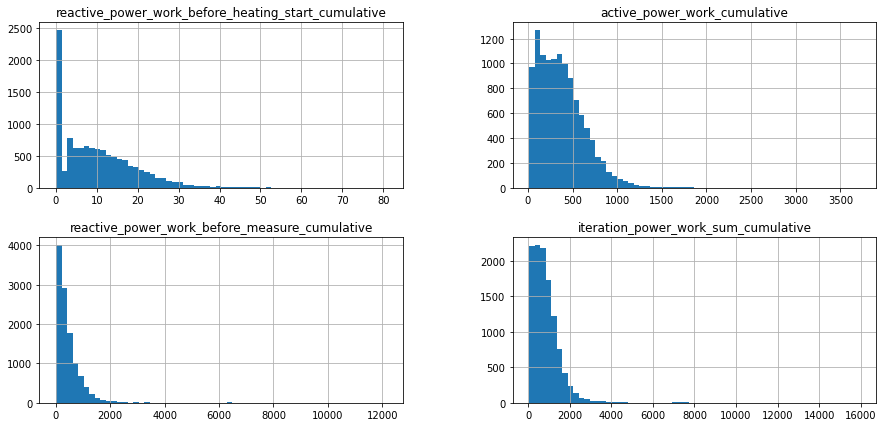

In [ ]:
# распределения накопленных работ разных мощностей

data_power_work.hist(bins=60, figsize=(15,7));

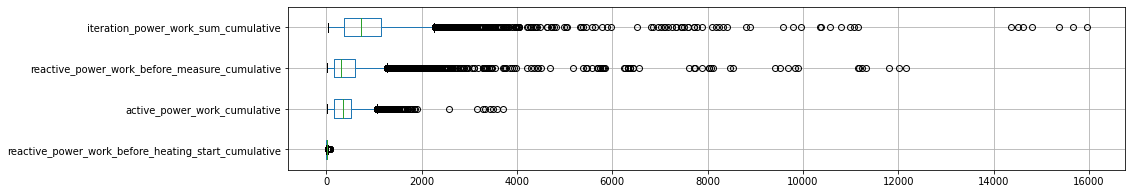

In [ ]:
data_power_work.boxplot(figsize=(15,3), vert=False);

Сильно выделяются накопленная работа реактивной мощности до измерения тмпературы и суммарная накопленная работа: всему виной большие промежутки времени после конца нагрева и до измерения.

In [ ]:
# снова посмотрим корреляцию всех признаков с конечной температурой

data_final.corr()['temp'].sort_values(ascending=False)

temp                                                   1.000000
wire_1                                                 0.321203
key_first_temp                                         0.297357
heating_sec_cumulative                                 0.280427
bulk_12                                                0.269956
bulk_15                                                0.269238
active_power_work_cumulative                           0.259619
bulk_4                                                 0.187911
reactive_power_work_before_heating_start_cumulative    0.177842
iteration_power_work_sum_cumulative                    0.130034
previous_reactive_power_mean                           0.109718
bulk_14                                                0.109592
reactive_power_work_before_measure_cumulative          0.052710
gas                                                    0.051927
active_power_mean                                      0.036138
reactive_power_mean                     

Конечная температура больше всего связана с материалом `wire_1` (0.32) и стартовой температурой по партии (0.29).

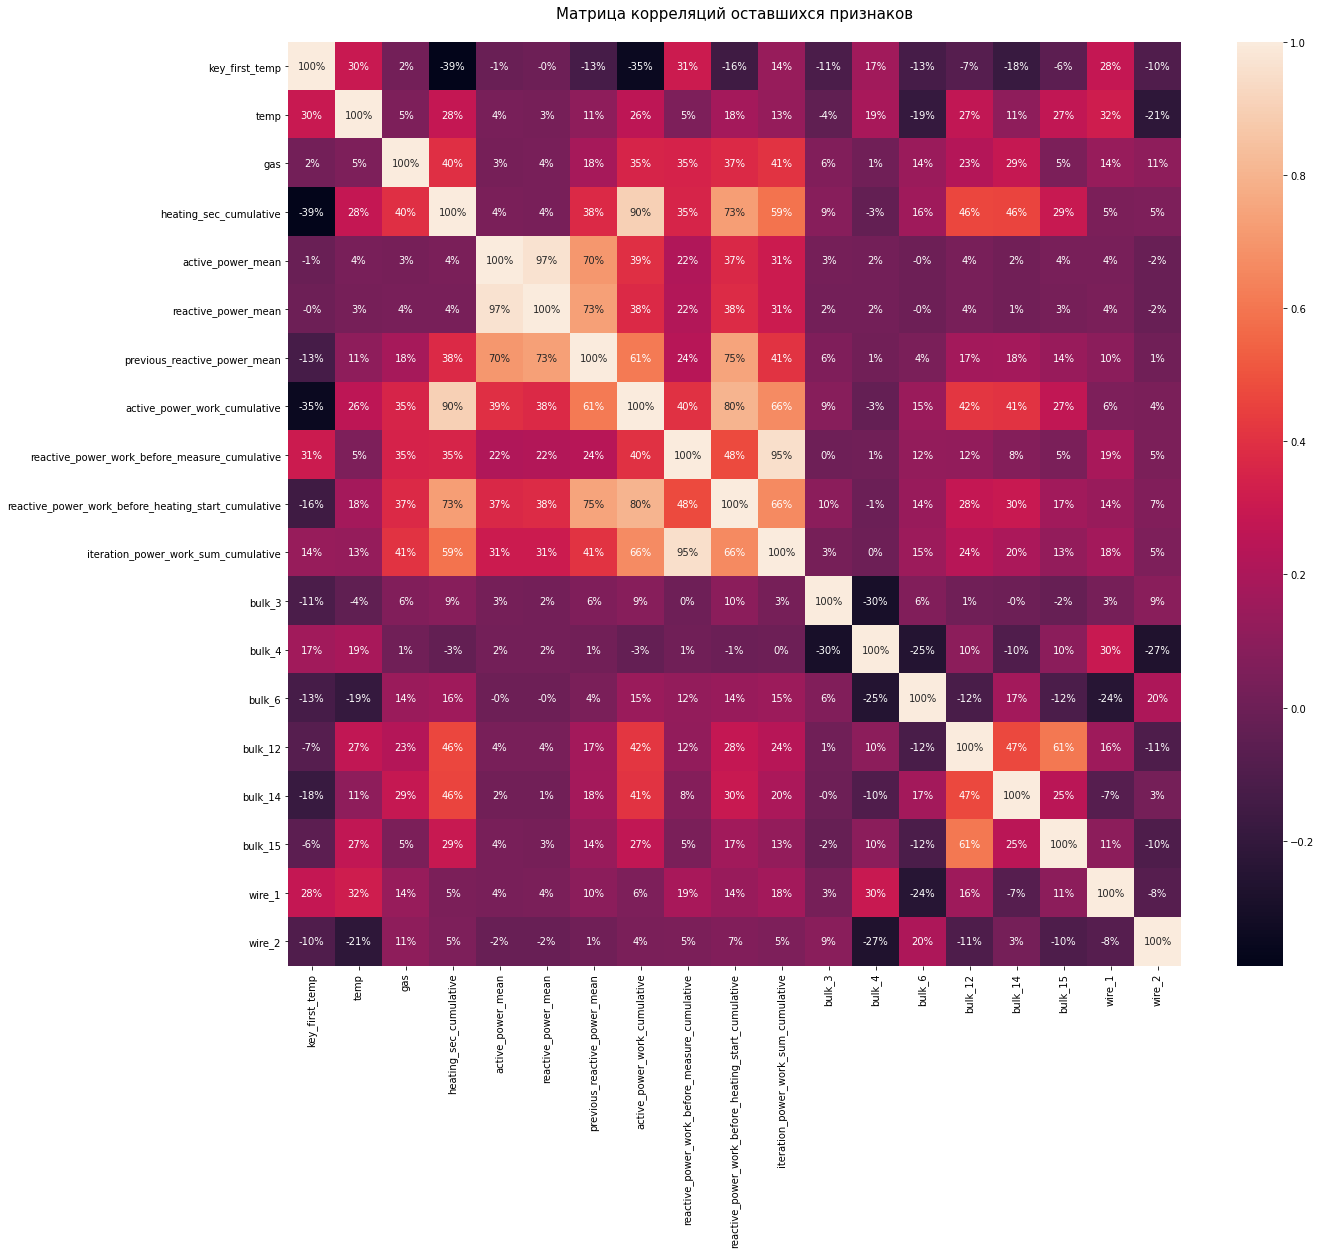

In [ ]:
# снова посмотрим на матрицу корреляций

plt.figure(figsize=(20, 17))
sns.heatmap(data_final.corr(), annot=True, fmt='.0%')
plt.title('Матрица корреляций оставшихся признаков'+'\n', fontsize=15);

Выявлены следующие заметные корреляции:
- 97% средняя активная мощность со средней реактивной мощностью.
- 95% накопленная работа реактивной мощности до измерения температуры с суммарной накопленной работой.
- 90% суммарное время нагрева с накопленной работой активной мощности.

Удалим накопленную работу активной мощности, среднюю реактивную мощность и суммарную накопленную работу.

In [ ]:
drop_columns = ['active_power_work_cumulative', 'reactive_power_mean',\
               'iteration_power_work_sum_cumulative']

In [ ]:
data_final.drop(drop_columns, axis=1, inplace=True)

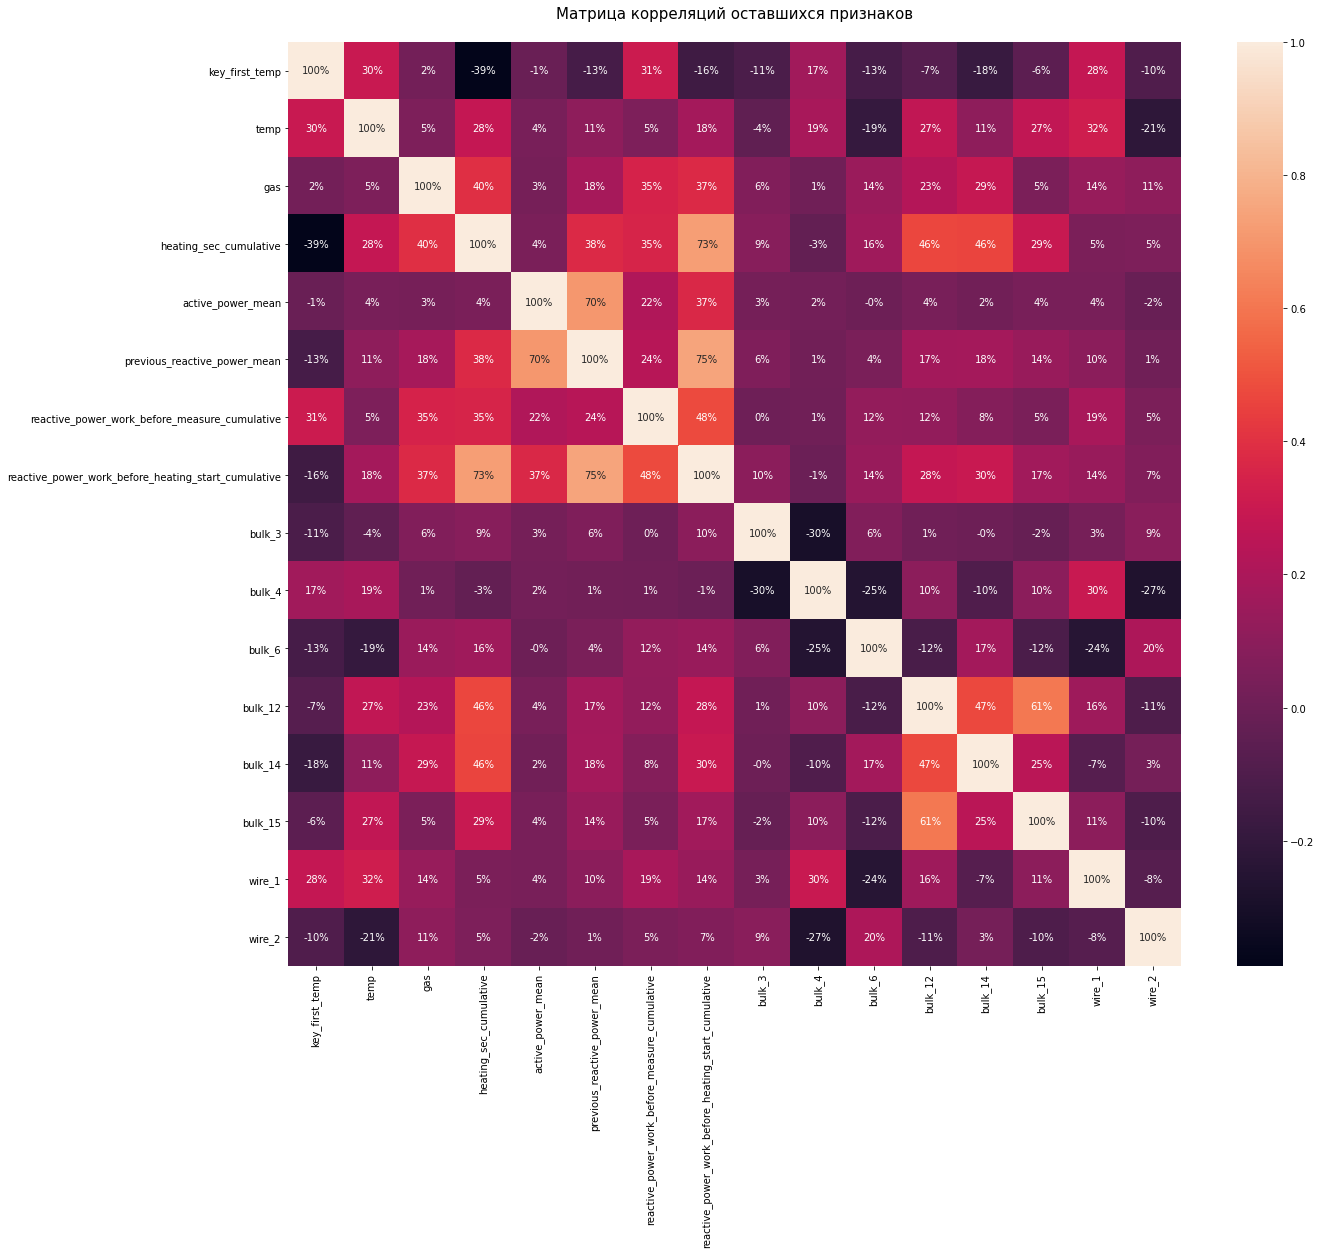

In [ ]:
# снова посмотрим на матрицу корреляций

plt.figure(figsize=(20, 17))
sns.heatmap(data_final.corr(), annot=True, fmt='.0%')
plt.title('Матрица корреляций оставшихся признаков'+'\n', fontsize=15);

Мультиколлинеарность минимизирована.

**Вывод**

Оценка корреляции показывает, что конечная температура больше всего связана с объемом материала `wire_1`, суммарным временем нагревания и стартовой температурой по партии.

## Обучение моделей

Подготовим выборки к обучению. Разделим данные на обучающую и тестовую выборки.

In [ ]:
train, test = train_test_split(data_final, test_size=0.25, random_state=170723)

features_train = train.drop('temp', axis=1)
target_train = train['temp']

features_test = test.drop('temp', axis=1)
target_test = test['temp']

In [ ]:
# отмасштабируем признаки

scaler = StandardScaler()
scaler.fit(features_train)
features_train[features_train.columns] = scaler.transform(features_train[features_train.columns])
features_test[features_test.columns] = scaler.transform(features_test[features_test.columns])

In [ ]:
print('Размер обучающей выборки', features_train.shape)
print('Размер тестовой выборки', features_test.shape)

Размер обучающей выборки (1725, 15)
Размер тестовой выборки (575, 15)


Напишем функцию для обучения и оценки модели.

In [ ]:
def model_estimator(model, params, features_train, target_train, title=None):
    model = RandomizedSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    model.fit(features_train, target_train)
    print(f'Лучшие гиперпараметры {title}:', model.best_params_)
    mae = -model.best_score_
    print('MAE:', mae)
    return mae

Протестируем модели Лассо, Случайный лес, Ридж и LightGBM.

In [ ]:
lasso = Lasso(random_state=170723)
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
lasso = model_estimator(lasso, lasso_params, features_train, target_train, 'Лассо')

Лучшие гиперпараметры Лассо: {'alpha': 0.03}
MAE: 6.1341353492036435


In [ ]:
rf = RandomForestRegressor(random_state=170723)
rf_params = {'n_estimators': [500, 700], 'max_depth': [10, 15]}
rf = model_estimator(rf, rf_params, features_train, target_train, 'Случайного леса')

Лучшие гиперпараметры Случайного леса: {'n_estimators': 500, 'max_depth': 10}
MAE: 6.173930094705176


In [ ]:
ridge = Ridge(random_state=170723)
ridge_params = {'alpha':[0, 0.01, 0.02, 0.024, 0.025, 0.026, 0.03]}
ridge = model_estimator(ridge, ridge_params, features_train, target_train, 'Ридж')

Лучшие гиперпараметры Ридж: {'alpha': 0.03}
MAE: 6.142162478206007


In [ ]:
%%time

lgbm = LGBMRegressor(random_state=170723)
lgbm_params = {'learning_rate':[0.01, 0.05, 0.1]}
lgbm = model_estimator(lgbm, lgbm_params, features_train, target_train, 'LightGBM')

Лучшие гиперпараметры LightGBM: {'learning_rate': 0.1}
MAE: 6.271450457911396
CPU times: user 22min 38s, sys: 4.6 s, total: 22min 43s
Wall time: 22min 48s


In [ ]:
# сравнительная таблица результатов моделей

models_results = pd.DataFrame([lasso, rf, ridge, lgbm], columns=['MAE'],
                 index=['Лассо', 'Случайный лес', 'Ридж', 'LightGBM'])
models_results

,MAE
Лассо,6.134135
Случайный лес,6.173930
Ридж,6.142162
LightGBM,6.271450


**Вывод**

Лучшей оказалась модель Лассо (MAE = 6.13).

## Тестирование лучшей модели

In [ ]:
# тестируем лучшую модель

lasso = Lasso(alpha=0.03, random_state=170723)
lasso.fit(features_train, target_train)
predictions = lasso.predict(features_test)
print('MAE:', mean_absolute_error(target_test, predictions))

MAE: 5.820949952242692


In [ ]:
# тестируем Случайный лес (для дальнейшего анализа важности признаков)

rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=170723)
rf.fit(features_train, target_train)
predictions = rf.predict(features_test)
print('MAE:', mean_absolute_error(target_test, predictions))

MAE: 5.83656808544208


In [ ]:
# сравним с результатом глупой модели на тестовой выборке

dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)
dummy_predictions = dummy.predict(features_test)
print('MAE:', mean_absolute_error(target_test, dummy_predictions))

MAE: 8.075109262759922


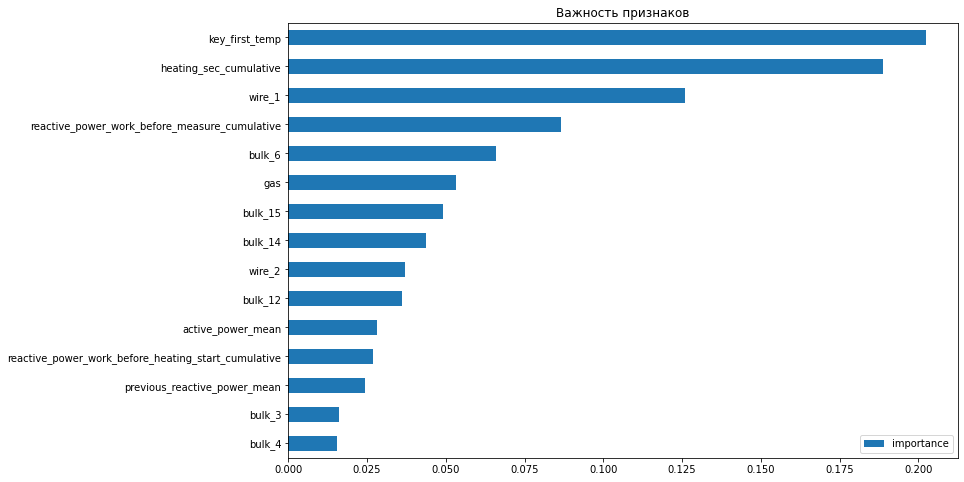

In [ ]:
# выведем важность признаков для предсказания моделью Случайного леса,
# т.к. у модели Лассо такой опции нет

imp = pd.DataFrame(rf.feature_importances_, index=features_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))
plt.title('Важность признаков');

**Вывод**

Результат работы лучшей модели на тестовой выборке MAE = 5.82. Самыми важными признаками для предсказания оказались стартовая температура по партии, длительность нагревания и  объем материала `wire_1`.

## Общий вывод

Провели предобработку данных. Удалили выбросы с низкой температурой (менее 1300 градусов) и аномальные значения реактивной мощности (-715).
Удалили из обучения материалы `wire 6, 3, 9, 8, 4, 7, 5` и `bulk 1, 11, 10, 5, 7, 2, 9, 13, 8` т.к. они использовались в менее 10% партий.
Собрали все данные в единый датасет: восстановили логику работы ковша и смоделировали весь процесс в хнологическом порядке. Объединили все итерации одной партии в одну строку, оставив важные для партии признаки.
Провели оценку новых признаков на мультиколлинеарность.
Протестировали 4 модели: Лассо, Случайный лес, Ридж и LightGBM. На кросс-валидации лучшей оказалась модель Лассо: MAE 6.13 на обучающей выборке. На тестовой выборке лучшая модель показала MAE 5.82.
Самыми важными признаками для предсказания оказались стартовая температура по партии, длительность нагревания и  объем материала `wire_1`.
Для решения данной задачи рекомендуется модель Лассо с гипперпараметрами `alpha=0.03`.

## Отчет

По итогу были выполнены все пункты ранее составленного плана.
Была проделана следующая работа:
1. Обработали найденные пропуски и выбросы в отдельных таблицах (температура менее 1300 градусов) и аномальные значения реактивной мощности (-715).
2. Единый датасет создали на основе таблицы с данными об электродах (в него добавляли недостающие данные).
3. Подтянули в основной датасет колонки с информацией о газе из таблицы о продувке сплава газом.
4. Расчитали средние величины каждого вида мощности в рамках одной партии и суммарное время нагревания в партии.
5. Благодаря данным об измерении температуры добавили колонки со стартовой температурой партии, предыдущей и конечной (целевой).
6. На основе подтянутых дат и расчитанных промежутков времени между этапами процесса посчитали работы каждого вида мощности, накопленные работы каждого вида мощности и суммарную накопленную работу.
7. Провели предобработку и переструктурировали таблицы с данными о подаче сыпучих и проволочных материалов, удалили редко используемые материалы, добавили колонки с материалами в каждую итерацию каждой партии.
8. Объединили данные всех итераций в рамках одной партии и составили таблицу - одна строка - одна партия - один ковш.
9. Оставили колонки со стартовой температурой партии, конечной температурой, газом, накопленным временем нагревания, средними мощностями, накопленными работами мощностей и использованными материалами.
10. Оставили только те партии, где были использованы и сыпучие и проволочные материалы.
11. Провели проверку финальных признаков на на мультиколлинеарность: исключили из обучения накопленную работу активной мощности, среднюю реактивную мощность и суммарную накопленную работу.

Список финальных признаков: стартовая температура партии, конечная температура (целевой), газ, суммарное время нагревания, средняя активная мощность, средняя реактивная мощность до нагревания, накопленные работы реактивных мощностей до нагревания и до измерения температуры. В качетсве предобработки было сделано масштабирование признаков.

Основная сложность заключалась в добавлении в единый датасет данных о подаче материалов. Для этого было написано две функции:
- объединяющая и переструктурирующая при помощи `melt` данные с объемом и временем подачи материалов в единую таблицу.
- добавляющая данные по каждому материалу в финальный датасет с учетом всех ранее добавленных в партии материалов.

Были протестированы 4 модели: Лассо, Случайный лес, Ридж и LightGBM. Лучшей моделью оказалась модель Лассо (на кросс-валидации MAE 6.13) с гипперпараметрами `alpha=0.03` и `random_state=170723`. MAE на тестовой выборке 5.82. Самыми важными признаками для предсказания оказались стартовая температура по партии, длительность нагревания и объем материала `wire_1`. Для улучшения решения рекомендуется обучать модель на несгруппированных по одной партии данных, а на отдельных итерациях внутри одной партии: это сделает модель более чувствительной и способной сэкономить ресурсы даже на отдельных итерациях.